In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import torch
import torch.nn as nn
from torch.utils import data

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
GPU_NUM = 0
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available else 'cpu')
torch.cuda.set_device(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.__version__)

Tesla T4
True
1.13.1+cu116


In [ ]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super(Discriminator,self).__init__()
        self.disc=nn.Sequential(
            nn.Conv2d(channels_img,features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d,features_d*2,4,2,1),
            self._block(features_d*2,features_d*4,4,2,1),
            self._block(features_d*4,features_d*8,4,2,1),
            nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=1),
            nn.Sigmoid(), )

    def _block(self, in_channels, out_channels, kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),)

    def forward(self,x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self,z_dim,channels_img,features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim,features_g*16,4,1,0),
            self._block(features_g*16,features_g*8,4,2,1),
            self._block(features_g*8,features_g*4,4,2,1),
            self._block(features_g*4,features_g*2,4,2,1),
            nn.ConvTranspose2d(
                features_g*2, channels_img,kernel_size=4,stride=2,padding=1,
            ),
            nn.Tanh(),
        )
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self,x):
        return self.gen(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)

In [ ]:
def show_image(dataset, times):
    for i in range(times):
        t = random.randint(1,len(dataset))
        temp_image = dataset.data[t]
        temp_image = np.array(temp_image, dtype='float')
        pixels = temp_image.reshape((28, 28))
        plt.figure(figsize=(2,2))
        plt.imshow(pixels, cmap='gray')
        plt.show()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



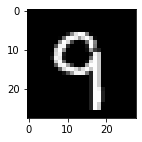

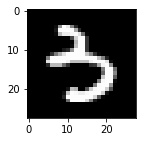

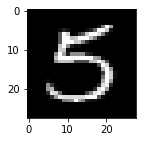

In [ ]:
dataset = datasets.MNIST(root="dataset/",train=True,download=True)
show_image(dataset,3)

In [ ]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS=40
FEATURES_DISC=64
FEATURES_GEN=64

tensor([5, 0, 4,  ..., 5, 6, 8])
60000


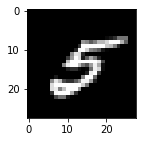

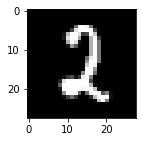

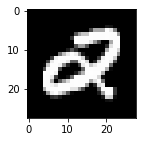

tensor([5, 0, 4,  ..., 5, 6, 8])
60000


In [ ]:
dataset = datasets.MNIST(root='dataset/',download=True,train=True,transform=transforms)
SPLIT={0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
for i in range(len(dataset.targets)):
    SPLIT[dataset.targets[i].item()].append(i)

def split(data,target):
    data.data = data.data[SPLIT[target]]
    data.targets = data.targets[SPLIT[target]]

Transforms = transforms.Compose([
                                 transforms.Resize(IMAGE_SIZE),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)],[0.5 for _ in range(CHANNELS_IMG)]),
])

one_data = datasets.MNIST(root="dataset/",train=True,transform=Transforms,download=True)
print(one_data.targets)
print(len(one_data))


### 이 한 줄을 주석처리시키면
### 60000개 데이터 전부 사용해서 학습을 시킬 수 있다.
# split(one_data,3)


show_image(one_data,3)
print(one_data.targets)
print(len(one_data))

Progress : [ 1 / 40 ], Time : 3.282 (min) 
Progress : [ 2 / 40 ], Time : 6.455 (min) 
Progress : [ 3 / 40 ], Time : 9.608 (min) 
Progress : [ 4 / 40 ], Time : 12.747 (min) 
Progress : [ 5 / 40 ], Time : 15.882 (min) 
Progress : [ 6 / 40 ], Time : 19.013 (min) 
Progress : [ 7 / 40 ], Time : 22.144 (min) 


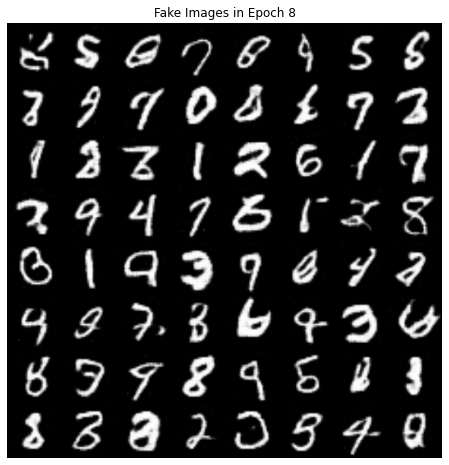

Progress : [ 8 / 40 ], Time : 25.281 (min) 
Progress : [ 9 / 40 ], Time : 28.409 (min) 
Progress : [ 10 / 40 ], Time : 31.540 (min) 
Progress : [ 11 / 40 ], Time : 34.678 (min) 
Progress : [ 12 / 40 ], Time : 37.809 (min) 
Progress : [ 13 / 40 ], Time : 40.948 (min) 
Progress : [ 14 / 40 ], Time : 44.072 (min) 
Progress : [ 15 / 40 ], Time : 47.198 (min) 


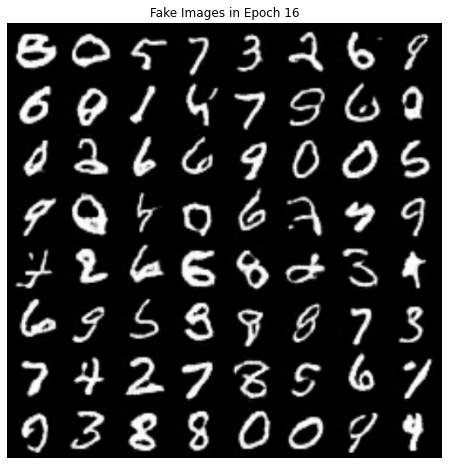

Progress : [ 16 / 40 ], Time : 50.339 (min) 
Progress : [ 17 / 40 ], Time : 53.457 (min) 
Progress : [ 18 / 40 ], Time : 56.576 (min) 
Progress : [ 19 / 40 ], Time : 59.697 (min) 
Progress : [ 20 / 40 ], Time : 62.812 (min) 
Progress : [ 21 / 40 ], Time : 65.937 (min) 
Progress : [ 22 / 40 ], Time : 69.046 (min) 
Progress : [ 23 / 40 ], Time : 72.164 (min) 


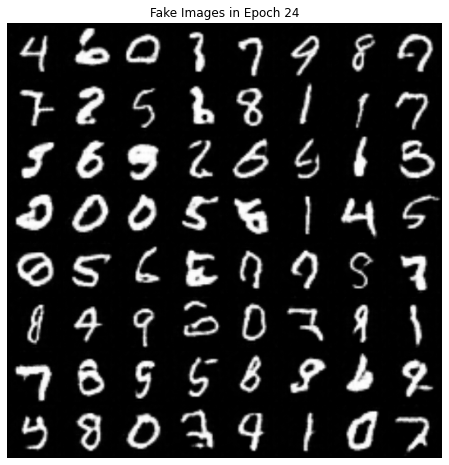

Progress : [ 24 / 40 ], Time : 75.288 (min) 
Progress : [ 25 / 40 ], Time : 78.416 (min) 
Progress : [ 26 / 40 ], Time : 81.545 (min) 
Progress : [ 27 / 40 ], Time : 84.677 (min) 
Progress : [ 28 / 40 ], Time : 87.806 (min) 
Progress : [ 29 / 40 ], Time : 90.931 (min) 
Progress : [ 30 / 40 ], Time : 94.058 (min) 
Progress : [ 31 / 40 ], Time : 97.186 (min) 


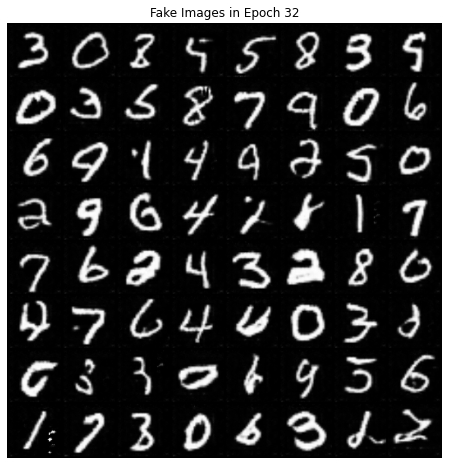

Progress : [ 32 / 40 ], Time : 100.324 (min) 
Progress : [ 33 / 40 ], Time : 103.425 (min) 
Progress : [ 34 / 40 ], Time : 106.535 (min) 
Progress : [ 35 / 40 ], Time : 109.651 (min) 
Progress : [ 36 / 40 ], Time : 112.775 (min) 
Progress : [ 37 / 40 ], Time : 115.893 (min) 
Progress : [ 38 / 40 ], Time : 119.005 (min) 
Progress : [ 39 / 40 ], Time : 122.124 (min) 


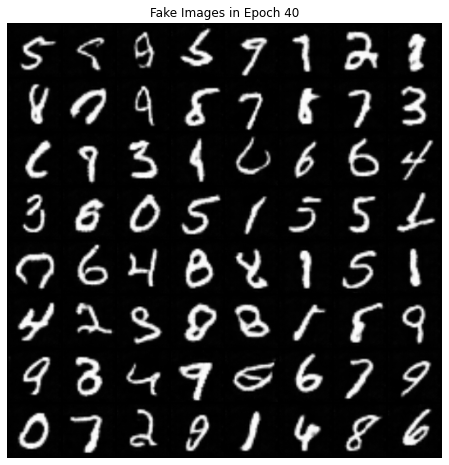

Progress : [ 40 / 40 ], Time : 125.247 (min) 


In [ ]:
One_Data_Loader=DataLoader(one_data,batch_size=BATCH_SIZE, shuffle=True)
One_gen = Generator(Z_DIM, CHANNELS_IMG , FEATURES_GEN).to(device)
One_disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(One_gen)
initialize_weights(One_disc)
opt_gen = optim.Adam(One_gen.parameters(), lr = LEARNING_RATE, betas=(0.5,0.999))
opt_disc = optim.Adam(One_disc.parameters(), lr = LEARNING_RATE, betas=(0.5,0.999))
criterion = nn.BCELoss()

One_gen.train()
One_disc.train()
Start_Time = time.time()

for epoch in range(NUM_EPOCHS):

		### 이 아래의 for 문 한 줄에서 y 값을 사용하고 있지 않음을 알 수 있습니다.
    for batch_idx, (real,_) in enumerate(One_Data_Loader):

        real = real.to(device)
        noise = torch.randn((BATCH_SIZE,Z_DIM,1,1)).to(device)
        fake = One_gen(noise)

        disc_real = One_disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = One_disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real+loss_disc_fake)/2

        One_disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        output = One_disc(fake).reshape(-1)
        loss_gen = criterion(output,torch.ones_like(output))
        One_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    if (epoch+1)%(max(1,NUM_EPOCHS//5))==0:
        Z = torch.randn(100,100,1,1).to(device)
        out_gen = One_gen(Z)
        Image_Loader=DataLoader(out_gen,batch_size=64, shuffle=True)
        real_batch = next(iter(Image_Loader))
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Fake Images in Epoch {}".format(epoch+1))
        plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()

    print("Progress : [ {} / {} ], Time : {:.3f} (min) ".format(epoch+1,NUM_EPOCHS,(time.time()-Start_Time)/60) )